In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import numpy as np
import pickle
##训练集 3000样本
train_df = pd.read_csv("dsjtzs_txfz_training.txt",header=None,delim_whitespace=True)
train_df.columns = ["id","points_str","target_point","label"]
##


# ## 预测集10w样本
# predict_df = pd.read_csv("dsjtzs_txfz_test1.txt",header=None,delim_whitespace=True)
# predict_df.columns = ["id","points_str","target_point"]
# train_df=predict_df
# ##

train_df.set_index(["id"],inplace=True)

def f(s):
    s =str(s)
    return s[0:-1]
train_df["points_str"]= train_df["points_str"].apply(f)


def  point_sort(x,y):
    if (x[2]>y[2]):
        return 1
    elif (x[2]<y[2]):
        return -1
    else:
        return 0
def f(t):
    s=str(t["points_str"])
    splited=s.split(";")
    ret = []
    for item in splited:
        item_splited = item.split(",")
        item_tuple = ( int(item_splited[0]),  int(item_splited[1]) ,int(item_splited[2]) )
        ret.append(item_tuple)
    sorted_arr = sorted(ret,point_sort)
    return pd.Series({"points_sorted_list":sorted_arr})
train_df["points_sorted_list"]=train_df[["points_str"]].apply(f,axis=1)

def f(s):
    sorted_arr=s["points_sorted_list"]
    _sum_x =0 
    _sum_y=0 
    _count =0
    ret=[]
    for i in range(0,len(sorted_arr)-1):
        if (sorted_arr[i][2]!=sorted_arr[i+1][2]):
                if _count==0:
                    ret.append(sorted_arr[i])
                else:
                    _count +=1
                    _sum_x+=sorted_arr[i][0]
                    _sum_y+=sorted_arr[i][1]
                    average_x =float( _sum_x ) / _count
                    average_y =float(_sum_y)/_count
                    ret.append((average_x,average_y,sorted_arr[i][2]))
                    _count =0
                    _sum_x=0
                    _sum_y=0
        else: 
            _sum_x += sorted_arr[i][0]
            _sum_y+=sorted_arr[i][1]
            _count+=1
    
    index = len(sorted_arr)-1
    if (sorted_arr[index][2] == sorted_arr[index-1][2]):
        _count+=1
        _sum_x+=sorted_arr[index][0]
        _sum_y+=sorted_arr[index][1]
        average_x =float( _sum_x ) / _count
        average_y =float(_sum_y)/_count
        ret.append((average_x,average_y,sorted_arr[index][2]))
    else:
        ret.append(sorted_arr[index])
    return pd.Series({"points_diff_time_list":ret})

train_df["points_diff_time_list"]=train_df[["points_sorted_list"]].apply(f,axis=1)

# points 都有数据
#print pd.isnull(train_df["points"]).value_counts()

# 2600 个1 正例；400个0 负例 (id:2601-3000)
#train_df.label.value_counts()

# id 都是不同的
#train_df.id.value_counts().shape[0]

In [13]:
def f_x(s):     
    ret =[]
    for item in s:
        ret.append(int(item[0]))
    return pd.Series({"points_x":ret})
        
train_df["points_x"]= train_df["points_diff_time_list"].apply(f_x)

def f_y (s): 
    ret=[]
    for item in s:
        ret.append(int(item[1]))
    return pd.Series({"points_y":ret})
train_df["points_y"]=train_df["points_diff_time_list"].apply(f_y)

def f_time (s):
    ret=[]
    for item in s:
        ret.append(int(item[2]) )
    return pd.Series({"points_time":ret})
train_df["points_time"]=train_df["points_diff_time_list"].apply(f_time)

def f_target_point_x(s):
    s = str(s)
    splited = s.split(",")
    return float(splited[0])
train_df["target_point_x"]=train_df["target_point"].apply(f_target_point_x)

def f_target_point_y (s):
    s =str(s)
    splited =s.split(",")
    return float(splited[1])
train_df["target_point_y"]=train_df["target_point"].apply(f_target_point_y)


# 3000条训练数据
train_df =train_df[["points_x","points_y","points_time","target_point_x","target_point_y","target_point","label"]]
# 人的轨迹是负例，机器的是正例，与题目中recall 计算方式一致
train_df["label"]=train_df["label"]-1
for i in range(2601,3001):
    train_df.loc[i,"label"]=1
##

# ##10w条预测集
# train_df =train_df[["points_x","points_y","points_time","target_point_x","target_point_y","target_point"]]
# ##

#去掉points就１个的, id有：493,2019　(points没有２个的，就不用删除２个的了)
def filter(s):
    if len(s)<=2:
        return False
    return True
filters = train_df["points_x"].apply(filter)
train_df=train_df[filters]


print train_df[:10]
print train_df.tail(10)


                                             points_x  \
id                                                      
1   [353, 367, 388, 416, 500, 584, 675, 724, 780, ...   
2   [283, 290, 297, 304, 311, 325, 339, 346, 360, ...   
3   [255, 297, 353, 423, 479, 542, 605, 668, 745, ...   
4   [437, 549, 605, 661, 731, 780, 822, 871, 885, ...   
5   [248, 255, 297, 339, 451, 577, 717, 885, 948, ...   
6   [171, 178, 178, 206, 353, 486, 668, 815, 899, ...   
7   [227, 234, 241, 248, 255, 262, 269, 276, 283, ...   
8   [199, 241, 255, 283, 339, 395, 465, 493, 507, ...   
9   [178, 192, 199, 206, 220, 227, 241, 255, 262, ...   
10  [290, 318, 346, 374, 437, 493, 570, 675, 766, ...   

                                             points_y  \
id                                                      
1   [2607, 2607, 2620, 2620, 2620, 2620, 2620, 262...   
2   [2490, 2490, 2490, 2490, 2490, 2503, 2503, 250...   
3   [2503, 2503, 2529, 2542, 2555, 2568, 2581, 260...   
4   [2724, 2711, 2724, 2750, 2

45
(1018.0, 241.0)
-----------
67
(1602.5, 189.0)
-----------
29
(580.5, 1190.0)
-----------


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


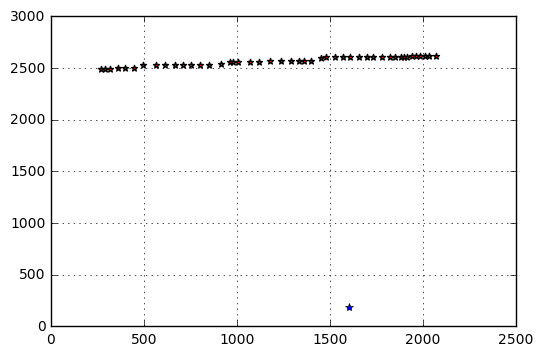

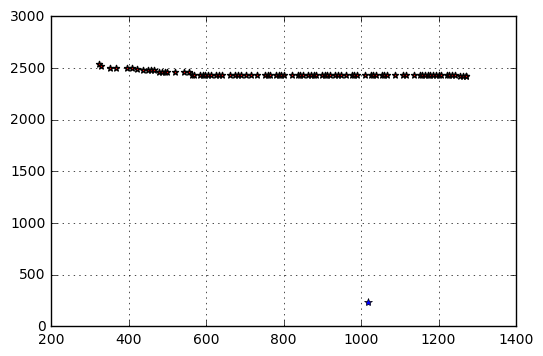

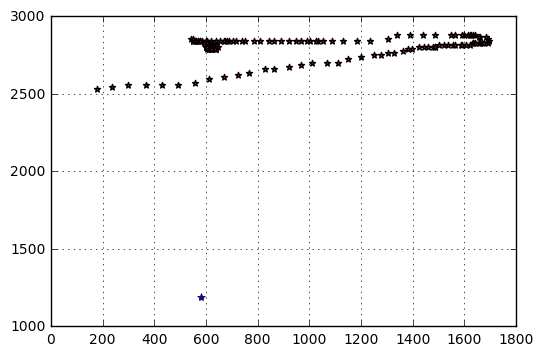

In [14]:
# plt.figure(figsize=(8,7),dpi=98)
# p1 = plt.subplot(211)
# p2 = plt.subplot(212)
# x = train_df.loc[1,"points_x"]
# y  = train_df.loc[1,"points_y"]
# target_x = train_df.loc[1,"target_point_x"]
# target_y = train_df.loc[1,"target_point_y"]
# print x
# print y
# p1.plot(x,y,'-',color='r',label="person")
# p1.plot(target_x,target_y,marker='*')
# p1.legend()
# plt.show()
ids = [45,67,29]
for id in ids:
    plt.figure(id)  #一个Figure对象可以包含多个子图（Axes）．指定了plt.figure(i)之后的操作就是在图表i 下进行的
    x = train_df.loc[id,"points_x"]
    y  = train_df.loc[id,"points_y"]
    target_x = train_df.loc[id,"target_point_x"]
    target_y = train_df.loc[id,"target_point_y"]
#     print x
#     print y
    print id
    print (target_x,target_y)
    print "-----------"
    if train_df.loc[id,"label"]==1:
        labelStr="person"
    else:
        labelStr="robort"
    plt.scatter(x,y,c="r",marker="*")
#  plt.plot(x,y,'-',color='r',label=labelStr)
    plt.plot(target_x,target_y,marker='*')
    plt.grid(True)
    plt.legend()
plt.show()

In [ ]:
def  f (s):
    ret = []
    points_x= s["points_x"]
    points_time =s["points_time"]
    for x in range(1,len(points_x)):
        velocity = (float(points_x[x])-points_x[x-1])/(float(points_time[x])-points_time[x-1])
        ret.append(velocity)
    return pd.Series({"velocity_x":ret})
train_df["velocity_x"]= train_df[["points_x","points_time"]].apply(f,axis=1)
 

def f(s):
    ret =[]
    points_y = s["points_y"]
    points_time = s["points_time"]
    for x in range(1,len(points_y)):
        velocity = (float(points_y[x])-points_y[x-1])/(float(points_time[x])-points_time[x-1])
        ret.append(velocity)
    return pd.Series({"velocity_y":ret})
train_df["velocity_y"]=train_df[["points_y","points_time"]].apply(f,axis=1)

def f(s):
    ret =[]
    velocity_x =s["velocity_x"]
    times = s["points_time"]
    if len(velocity_x)>1:
        for x in range (1,len (velocity_x)):
            accelerate_x = (float(velocity_x[x])- velocity_x[x-1])/((float(times[x+1])+times[x])/2 - (float(times[x])+times[x-1])/2)
            ret.append(accelerate_x)
    return pd.Series({"accelerate_x":ret})
train_df["accelerate_x"]=train_df[["velocity_x","points_time"]].apply(f,axis=1)


def f(s):
    ret = []
    velocity_y =s["velocity_y"]
    times=s["points_time"]
    if (len(velocity_y)>1):
        for x in range(1,len(velocity_y)):
            accelerate_y = (float(velocity_y[x])-velocity_y[x-1])/((float(times[x+1])+times[x])/2 - (float(times[x])+times[x-1])/2)
            ret.append(accelerate_y)
    return pd.Series({"accelerate_y":ret})
train_df["accelerate_y"]=train_df[["velocity_y","points_time"]].apply(f,axis=1)


In [ ]:
# # 对于point就一个点的，速度就是０
# train_df["velocity_x"]=train_df["velocity_x"].apply(lambda x: [0] if (len(x)==0) else x )
# train_df["velocity_y"]=train_df["velocity_y"].apply(lambda x: [0] if(len(x)==0) else x)

# #对于速度就一个值的，加速度为０
# train_df["accelerate_x"]=train_df["accelerate_x"].apply(lambda x: [0] if (len(x)==0) else x)
# train_df["accelerate_y"]=train_df["accelerate_y"].apply(lambda x: [0] if (len(x)==0) else x)

# points y 的方差，points x 的方差
train_df["points_y_var"]=train_df["points_y"].apply(lambda x :np.var(x))
train_df["points_x_var"]=train_df["points_x"].apply(lambda x:np.var(x))

# 均值：速度　加速度
train_df["velocity_x_mean"]=train_df["velocity_x"].apply(lambda x: np.mean(np.array(x)))
train_df["velocity_y_mean"]=train_df["velocity_y"].apply(lambda x:np.mean(np.array(x)))
train_df["accelerate_x_mean"]=train_df["accelerate_x"].apply(lambda x:np.mean(np.array(x)))
train_df["accelerate_y_mean"]=train_df["accelerate_y"] .apply(lambda x:np.mean(np.array(x)))

# 方差：速度　加速度
train_df["velocity_x_var"]=train_df["velocity_x"].apply(lambda x:np.var(np.array(x)))
train_df["velocity_y_var"]=train_df["velocity_y"].apply(lambda x:np.var(np.array(x)))
train_df["accelerate_x_var"]=train_df["accelerate_x"].apply(lambda x:np.var(np.array(x)))
train_df["accelerate_y_var"]=train_df["accelerate_y"].apply(lambda x:np.var(np.array(x)))

# 最大值: 速度 加速度
train_df["max_velocity_x"] =train_df["velocity_x"].apply(lambda x: max(x))
train_df["max_velocity_y"] = train_df["velocity_y"].apply(lambda x:max(x))
train_df["max_accelerate_x"] = train_df["accelerate_x"].apply(lambda x:max(x))
train_df["max_accelerate_y"] = train_df["accelerate_y"].apply(lambda x:max(x))

# 最小值:速度 加速度
train_df["min_velocity_x"]= train_df["velocity_x"].apply(lambda x: min(x))
train_df["min_velocity_y"]=train_df["velocity_y"].apply(lambda x:min(x))
train_df["min_accelerate_x"]=train_df["accelerate_x"].apply(lambda x:min(x))
train_df["min_accelerate_y"]=train_df["accelerate_y"].apply(lambda x:min(x))

# count : 速度  (即count:加速度，count:路径中每个点的y 距离目标y的 距离 )
train_df["count_velocity"]= train_df["velocity_x"].apply(lambda x: len(x))
 


#25%: 速度　加速度
train_df["velocity_x_percentile_25"]=train_df["velocity_x"].apply(lambda x :np.percentile(x,25))
train_df["velocity_y_percentile_25"]=train_df["velocity_y"].apply(lambda x:np.percentile(x,25))
train_df["accelerate_x_percentile_25"]=train_df["accelerate_x"].apply(lambda x:np.percentile(x,25))
train_df["accelerate_y_percentile_25"]=train_df["accelerate_y"].apply(lambda x:np.percentile(x,25))

# 75% : 速度　加速度
train_df["velocity_x_percentile_75"]=train_df["velocity_x"].apply(lambda x:np.percentile(x,75))
train_df["velocity_y_percentile_75"]=train_df["velocity_y"].apply(lambda x:np.percentile(x,75))
train_df["accelerate_x_percentile_75"]=train_df["accelerate_x"].apply(lambda x:np.percentile(x,75))
train_df["accelerate_y_percentile_75"]=train_df["accelerate_y"].apply(lambda x:np.percentile(x,75))

# 50% :速度方差
train_df["velocity_x_percentile_50"]=train_df["velocity_x"].apply(lambda x:np.percentile(x,75))
train_df["velocity_y_percentile_50"]=train_df["velocity_y"].apply(lambda x:np.percentile(x,75))
train_df["accelerate_x_percentile_50"]=train_df["accelerate_x"].apply(lambda x:np.percentile(x,75))
train_df["accelerate_y_percentile_50"]=train_df["accelerate_y"].apply(lambda x:np.percentile(x,75))


train_df["x_mean"]=train_df["points_x"].apply(lambda x:np.mean(np.array(x)))
train_df["y_mean"]=train_df["points_y"].apply(lambda x:np.mean(np.array(x)))

# 路径中x 的平均值距离目标x的距离
def f(s):
    x_mean =s["x_mean"]
    target_point_x = s["target_point_x"]
    return x_mean-target_point_x
train_df["x_mean_dis_target_x"] = train_df[["x_mean","target_point_x"]].apply(f,axis=1)

# 路径中　y的平均值距离目标y的距离　
def f(s):
    y_mean =s["y_mean"]
    target_point_y = s["target_point_y"]
    return y_mean - target_point_y
train_df["y_mean_dis_target_y"]=train_df[["y_mean","target_point_y"]].apply(f,axis=1)

# 路径中每个点的x 距离目标x 的距离　（数组）
def f(s):
    points_x = s["points_x"]
    target_point_x =s["target_point_x"]
    ret=[]
    for i in range(0,len(points_x)):
        ret.append(points_x[i]-target_point_x)
    return pd.Series({"x_dis_target_point_x":ret})
train_df["x_dis_target_point_x"]=train_df[["points_x","target_point_x"]].apply(f,axis=1)

# 路径中点x 距离目标x 的最小距离，最大距离，等比分点，平均,方差
train_df["x_dis_target_point_x_min"]=train_df.x_dis_target_point_x.apply(lambda x:min(x))
train_df["x_dis_target_point_x_max"]=train_df.x_dis_target_point_x.apply(lambda x:max(x))
train_df["x_dis_target_point_x_25"]=train_df.x_dis_target_point_x.apply(lambda x: np.percentile(x,25))
train_df["x_dis_target_point_x_50"]=train_df.x_dis_target_point_x.apply(lambda x:np.percentile(x,50))
train_df["x_dis_target_point_x_75"]=train_df.x_dis_target_point_x.apply(lambda x:np.percentile(x,75))
train_df["x_dis_target_point_x_average"]=train_df.x_dis_target_point_x.apply(lambda x:np.mean(x))
train_df["x_dis_target_point_x_var"]=train_df.x_dis_target_point_x.apply(lambda x:np.var(x))

# 路径中每个点的y 距离目标y的 距离 （数组）
def f(s):
    points_y = s["points_y"]
    target_point_y = s["target_point_y"]
    ret = []
    for i in range(0,len(points_y)):
        ret.append(points_y[i]-target_point_y)
    return pd.Series({"y_dis_target_point_y":ret})
train_df["y_dis_target_point_y"]=train_df[["points_y","target_point_y"]].apply(f,axis=1)

# 路径中点y 距离目标y 的最小距离，最大距离，等比分点，平均,方差
train_df["y_dis_target_point_y_min"]=train_df.y_dis_target_point_y.apply(lambda x:min(x))
train_df["y_dis_target_point_y_max"]=train_df.y_dis_target_point_y.apply(lambda x:max(x))
train_df["y_dis_target_point_y_25"]=train_df.y_dis_target_point_y.apply(lambda x: np.percentile(x,25))
train_df["y_dis_target_point_y_50"]=train_df.y_dis_target_point_y.apply(lambda x:np.percentile(x,50))
train_df["y_dis_target_point_x_75"]=train_df.y_dis_target_point_y.apply(lambda x:np.percentile(x,75))
train_df["y_dis_target_point_y_average"]=train_df.y_dis_target_point_y.apply(lambda x:np.mean(x))
train_df["y_dis_target_point_y_var"]=train_df.y_dis_target_point_y.apply(lambda x:np.var(x))

# y 突变的次数 (台阶个数)
def f(s):
    ret =0
    for i in range(1,len(s)):
        if abs(s[i]-s[i-1])>=2:
            ret+=1
    return ret
train_df["y_diff_count"]=train_df["points_y"].apply(f)

# x多少个不变（每个台阶的长度,数组）
def f(s):
    ret = []
    count =1
    for i  in range(1,len(s)):
        if(s[i]==s[i-1]):
            count+=1
        else:
            ret.append(count)
            count=1
    ret.append(count)

    return pd.Series({"x_phases_length":ret})
    
train_df["x_phases_length"]=train_df["points_y"].apply(f)

# x_phases_length 的min max,25,50,75, mean,var,count
train_df["x_phase_length_min"]=train_df["x_phases_length"].apply(lambda x:min(x))
train_df["x_phase_length_max"]=train_df["x_phases_length"].apply(lambda x:max(x))
train_df["x_phase_length_25"]=train_df["x_phases_length"].apply(lambda x:np.percentile(x,25))
train_df["x_phase_length_50"]=train_df["x_phases_length"].apply(lambda x:np.percentile(x,50))
train_df["x_phase_length_75"]=train_df["x_phases_length"].apply(lambda x:np.percentile(x,75))
train_df["x_phase_length_mean"]=train_df["x_phases_length"].apply(lambda x:np.mean(x))
train_df["x_phase_length_var"]=train_df["x_phases_length"].apply(lambda x:np.var(x))
train_df["x_phase_length_count"]=train_df["x_phases_length"].apply(lambda x:len(x))



def f(s):
    target_point_x = float(s["target_point_x"])
    points_x = s["points_x"]
    points_time =s["points_time"]
    for i in range(0,len(points_x)):
        if (points_x[i]>target_point_x and i>=1):
            return (float(points_x[i])-float(points_x[i-1]))/(float(points_time[i])-float(points_time[i-1]))
    return 0
# target 附近x的速度
train_df["near_target_x_velocity"]=train_df[["points_time","points_x","target_point_x"]].apply(f,axis=1)

# target 附近x的速度 - 速度最大值
train_df["near_target_x_velocity_minus_max_velocity"]= train_df["near_target_x_velocity"]-train_df["max_velocity_x"]
# target 附近x的速度 - 速度最小值
train_df["near_target_x_velocity_minus_min_velocity"]=train_df["near_target_x_velocity"]-train_df["min_velocity_x"]
# target 附近x的速度 - 速度均值
train_df["near_target_x_velocity_minus_mean_velocity"]=train_df["near_target_x_velocity"]-train_df["velocity_x_mean"]

 

In [ ]:
## 对于预测集
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from sklearn.metrics import recall_score,make_scorer,precision_score

clf = joblib.load('rf_06_24_1.pkl')
test_x=train_df[["points_y_var","points_x_var","velocity_x_mean","velocity_y_mean","accelerate_x_mean","accelerate_y_mean","velocity_x_var","velocity_y_var","accelerate_x_var","accelerate_y_var",
                            "max_velocity_x","max_velocity_y","max_accelerate_x","max_accelerate_y","min_velocity_x","min_velocity_y","min_accelerate_x","min_accelerate_y","count_velocity","velocity_x_percentile_25",
                           "velocity_y_percentile_25", "accelerate_x_percentile_25","accelerate_y_percentile_25","velocity_x_percentile_75","velocity_y_percentile_75","accelerate_x_percentile_75","accelerate_y_percentile_75",
                            "velocity_x_percentile_50","velocity_y_percentile_50","accelerate_x_percentile_50","accelerate_y_percentile_50","x_mean_dis_target_x","y_mean_dis_target_y","x_dis_target_point_x_min",
                            "x_dis_target_point_x_max","x_dis_target_point_x_25","x_dis_target_point_x_50","x_dis_target_point_x_75","x_dis_target_point_x_average","x_dis_target_point_x_var","y_dis_target_point_y_min","y_dis_target_point_y_max",
                            "y_dis_target_point_y_25","y_dis_target_point_y_50","y_dis_target_point_x_75","y_dis_target_point_y_average","y_dis_target_point_y_var","y_diff_count","x_phase_length_min","x_phase_length_max","x_phase_length_25",
                           "x_phase_length_50", "x_phase_length_75","x_phase_length_mean","x_phase_length_var","x_phase_length_count",
                            "near_target_x_velocity","near_target_x_velocity_minus_max_velocity","near_target_x_velocity_minus_min_velocity",
                            "near_target_x_velocity_minus_mean_velocity"]]
# 删除重要度低的特征
del test_x["velocity_y_percentile_75"]
del test_x["accelerate_y_mean"]
del test_x["y_dis_target_point_y_50"]
del test_x["y_dis_target_point_y_max"]
del test_x["velocity_y_percentile_50"]

y_predict= clf.predict(test_x)


print y_predict.shape
print train_df.index.values.shape
result=pd.DataFrame ({"id":train_df.index.values,"result":y_predict})
result.to_csv('predict_result_6_24_1.csv', encoding='utf-8', index=False)

out=result[result["result"]==1]["id"]
print out.shape
out.to_csv('predict_submit_6_24_1.csv', encoding='utf-8', index=False)

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from sklearn.metrics import recall_score,make_scorer,precision_score
train_x= train_df[["points_y_var","points_x_var","velocity_x_mean","velocity_y_mean","accelerate_x_mean","accelerate_y_mean","velocity_x_var","velocity_y_var","accelerate_x_var","accelerate_y_var",
                            "max_velocity_x","max_velocity_y","max_accelerate_x","max_accelerate_y","min_velocity_x","min_velocity_y","min_accelerate_x","min_accelerate_y","count_velocity","velocity_x_percentile_25",
                           "velocity_y_percentile_25", "accelerate_x_percentile_25","accelerate_y_percentile_25","velocity_x_percentile_75","velocity_y_percentile_75","accelerate_x_percentile_75","accelerate_y_percentile_75",
                            "velocity_x_percentile_50","velocity_y_percentile_50","accelerate_x_percentile_50","accelerate_y_percentile_50","x_mean_dis_target_x","y_mean_dis_target_y","x_dis_target_point_x_min",
                            "x_dis_target_point_x_max","x_dis_target_point_x_25","x_dis_target_point_x_50","x_dis_target_point_x_75","x_dis_target_point_x_average","x_dis_target_point_x_var","y_dis_target_point_y_min","y_dis_target_point_y_max",
                            "y_dis_target_point_y_25","y_dis_target_point_y_50","y_dis_target_point_x_75","y_dis_target_point_y_average","y_dis_target_point_y_var","y_diff_count","x_phase_length_min","x_phase_length_max","x_phase_length_25",
                           "x_phase_length_50", "x_phase_length_75","x_phase_length_mean","x_phase_length_var","x_phase_length_count",
                            "near_target_x_velocity","near_target_x_velocity_minus_max_velocity","near_target_x_velocity_minus_min_velocity",
                            "near_target_x_velocity_minus_mean_velocity"]]
train_y =train_df["label"]

x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.2)

def scoring(y_true, y_pred):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    my_f_scorer = 100 * (5 * recall * precision / (3 * recall + 2 * precision))
    return my_f_scorer
my_scorer = make_scorer(scoring)
 
# person_indices=y_train[y_train.label==1].index
# robort_indices=y_train[y_train.label==0].index
# person_len = len(robort_indices)* 3
# person_random_indices = np.random.choice(person_indices, person_len, replace=False)

# x_train1 = pd.concat([x_train.loc[person_random_indices], x_train.loc[robort_indices]])
# y_train1= pd.concat([ y_train.loc[person_random_indices], y_train.loc[robort_indices]])

'''
max_depth ：限定了决策树的最大深度，对于防止过拟合非常有用。
min_samples_leaf ：限定了叶子节点包含的最小样本数，这个属性对于防止上文讲到的数据碎片问题很有作用。 (因为随着树的深度增加，叶子上的样本数会越来越少)
善用min_samples_split和min_samples_leaf参数来控制叶子节点的样本数量，防止overfitting。
平衡训练数据中的各个种类的数据，防止被一个种类的数据支配。


http://www.cnblogs.com/pinard/p/6160412.html
内部节点再划分所需最小样本数min_samples_split: 这个值限制了子树继续划分的条件，如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分。 默认是2.如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

叶子节点最少样本数min_samples_leaf: 这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。 默认是1,可以输入最少的样本数的整数，或者最少样本数占样本总数的百分比。如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。
'''
param1 = {'n_estimators':range(10,101,10),'max_depth':range(10,101,10)}
gv = GridSearchCV(estimator = RandomForestClassifier(random_state=10), 
                       param_grid = param1,scoring='f1',cv=5)
gv.fit(x_train,y_train)
print  gv.grid_scores_
print "---------"
print gv.best_params_
print "----------"
print gv.best_score_
 
# {'n_estimators': 40, 'max_depth': 21}
# ----------
# 0.997374774755
 


In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=10,oob_score=True)
rf.fit(x_train,y_train)
feature_importances = zip(rf.feature_importances_ , [ x for x in range(0,60)],[x_train.columns[i] for i in range(0,60)])
print feature_importances
print "----------------"
def sort_f(x,y):
    if (x[0]<y[0]):
        return -1
    elif (x[0]>y[0]):
        return 1
    else:
        return 0
sorted_feature_importances= sorted(feature_importances,sort_f)
print sorted_feature_importances
print "----------------"
print rf.oob_score_  
print "----------------"
y_predict = rf.predict(x_test)
print metrics.f1_score(y_test,y_predict)

In [ ]:
x_train= train_df[["points_y_var","points_x_var","velocity_x_mean","velocity_y_mean","accelerate_x_mean","accelerate_y_mean","velocity_x_var","velocity_y_var","accelerate_x_var","accelerate_y_var",
                            "max_velocity_x","max_velocity_y","max_accelerate_x","max_accelerate_y","min_velocity_x","min_velocity_y","min_accelerate_x","min_accelerate_y","count_velocity","velocity_x_percentile_25",
                           "velocity_y_percentile_25", "accelerate_x_percentile_25","accelerate_y_percentile_25","velocity_x_percentile_75","velocity_y_percentile_75","accelerate_x_percentile_75","accelerate_y_percentile_75",
                            "velocity_x_percentile_50","velocity_y_percentile_50","accelerate_x_percentile_50","accelerate_y_percentile_50","x_mean_dis_target_x","y_mean_dis_target_y","x_dis_target_point_x_min",
                            "x_dis_target_point_x_max","x_dis_target_point_x_25","x_dis_target_point_x_50","x_dis_target_point_x_75","x_dis_target_point_x_average","x_dis_target_point_x_var","y_dis_target_point_y_min","y_dis_target_point_y_max",
                            "y_dis_target_point_y_25","y_dis_target_point_y_50","y_dis_target_point_x_75","y_dis_target_point_y_average","y_dis_target_point_y_var","y_diff_count","x_phase_length_min","x_phase_length_max","x_phase_length_25",
                           "x_phase_length_50", "x_phase_length_75","x_phase_length_mean","x_phase_length_var","x_phase_length_count",
                            "near_target_x_velocity","near_target_x_velocity_minus_max_velocity","near_target_x_velocity_minus_min_velocity",
                            "near_target_x_velocity_minus_mean_velocity"]]
train_y =train_df["label"]
# 删除重要度低的特征
del x_train["velocity_y_percentile_75"]
del x_train["accelerate_y_mean"]
del x_train["y_dis_target_point_y_50"]
del x_train["y_dis_target_point_y_max"]
del x_train["velocity_y_percentile_50"]

rf = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=10,oob_score=True)
rf.fit(x_train,train_y)
feature_importances = zip(rf.feature_importances_ , [ x for x in range(0,55)],[x_train.columns[i] for i in range(0,55)])
sorted_feature_importances= sorted(feature_importances,sort_f)
f = open('rf_06_24_1_allset_feature_importance', 'wb')
pickle.dump(sorted_feature_importances, f)
joblib.dump(rf, 'rf_06_24_1_model.pkl')

sorted_feature_importances

In [ ]:
# 对于预测集
predict_df=pd.read_csv("predict_feature_6_24_1.csv")
y_predict= rf.predict(predict_df)
print y_predict
result=pd.DataFrame ({"result":y_predict})
result.result.value_counts()